# Neutron Emitting Spot Size - simulation of the experiment to calibrate the experiment

- MCNP results are in /Users/hkromer/02_PhD/02_Data/09.NeutronEmittingSpot/02.Experiment/lookup_table_simulation/df_MCNP_results_

## Plots to illustrate the calibration principle

1. Compute the total number of counts, assuming 9 hours of total measurement time

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import os, sys, glob
import re
from scipy.interpolate import interp1d
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import scipy
from scipy import stats
from scipy.stats import poisson
from scipy import optimize
from scipy.misc import derivative
import itertools
%matplotlib inline

import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

# import the two dataframes. They have the same settings, but different sizes in the MCNP source definition (gaussian profile)
dfs = []
for ii in [2,3]:
    
    fname = f'/Users/hkromer/02_PhD/02_Data/09.NeutronEmittingSpot/02.Experiment/lookup_table_simulation/df_MCNP_results_0{ii}.csv'
    _ = pd.read_csv(fname, index_col=0)
#     print(np.min(_['x_pos'].unique()),np.max(_['x_pos'].unique()) )
    dfs.append(_)    
data = pd.concat(dfs, ignore_index=True)
data = data.drop_duplicates() # 6 mm occurs in both datasets
# radius: MCNP6 gaussian source radius in cm
# x_pos: x position of the edge in mm
# nps: number of particles simulated in MCNP6
# diameter: source diameter gaussian in mm
# Cps_cutoff: counts per second in the detector, cutoff corrected

# properties are the same for all the three runs
fname = '/Users/hkromer/02_PhD/02_Data/09.NeutronEmittingSpot/02.Experiment/lookup_table_simulation/df_properties.csv'
props = pd.read_csv(fname, index_col=0)

master_folder = '/Users/hkromer/02_PhD/02_Data/09.NeutronEmittingSpot/02.Experiment/lookup_table_simulation'

data.head()

,case,radius,x_pos,run,nps,entering_tracks,population,F4_tot,R_tot,diameter,f,Cps,Cps_cutoff
0,0,0.005,-2.00,rad0.00500_x-0.20000,100000.0,22457,22456,0.798909,0.051243,0.1,0.008481,13037.273134,9777.954851
1,0,0.005,-1.95,rad0.00500_x-0.19500,100000.0,22457,22456,0.798909,0.051243,0.1,0.008481,13037.273134,9777.954851
2,0,0.005,-1.90,rad0.00500_x-0.19000,100000.0,22457,22456,0.798909,0.051243,0.1,0.008481,13037.273134,9777.954851
3,0,0.005,-1.85,rad0.00500_x-0.18500,100000.0,22457,22456,0.798909,0.051243,0.1,0.008481,13037.273134,9777.954851
4,0,0.005,-1.80,rad0.00500_x-0.18000,100000.0,22457,22456,0.798909,0.051243,0.1,0.008481,13037.273134,9777.954851


### 1. Compute the total number of counts, assuming 9 hours of total measurement time

- this is not so relevant, it just scales the Y axis

In [2]:
meas_time = 9*60*60 # measurement time in seconds
# data.groupby(['diameter']).apply(lambda x: print(x.shape, x.diameter.unique()))
# number of positions for each measurment, check with the above line if it is the same
num_pos_all = data.groupby(['diameter']).apply(lambda x: x.shape)
num_pos = num_pos_all.values[0][0]
for jj in num_pos_all.values:
    assert num_pos == jj[0]

time_per_pos = meas_time/num_pos # seconds

data['counts'] = data['Cps_cutoff'] * time_per_pos
data.head()

,case,radius,x_pos,run,nps,entering_tracks,population,F4_tot,R_tot,diameter,f,Cps,Cps_cutoff,counts
0,0,0.005,-2.00,rad0.00500_x-0.20000,100000.0,22457,22456,0.798909,0.051243,0.1,0.008481,13037.273134,9777.954851,2.215425e+06
1,0,0.005,-1.95,rad0.00500_x-0.19500,100000.0,22457,22456,0.798909,0.051243,0.1,0.008481,13037.273134,9777.954851,2.215425e+06
2,0,0.005,-1.90,rad0.00500_x-0.19000,100000.0,22457,22456,0.798909,0.051243,0.1,0.008481,13037.273134,9777.954851,2.215425e+06
3,0,0.005,-1.85,rad0.00500_x-0.18500,100000.0,22457,22456,0.798909,0.051243,0.1,0.008481,13037.273134,9777.954851,2.215425e+06
4,0,0.005,-1.80,rad0.00500_x-0.18000,100000.0,22457,22456,0.798909,0.051243,0.1,0.008481,13037.273134,9777.954851,2.215425e+06


### 2. Plot some ESFs

The ESF is fitted using:
- use of a logistic fermi function as fit to the ESF: <br>
Li, T. et al. Comparison of different analytical edge spread function models for MTF
calculation using curve-fitting. 74981H (2009). doi:10.1117/12.832793
$$f(x,a,b,c) = \frac{a}{1+\text{exp}\left[-\frac{x-b}{c}\right]}$$
$$\text{FWHM} = 3.53 \cdot c$$


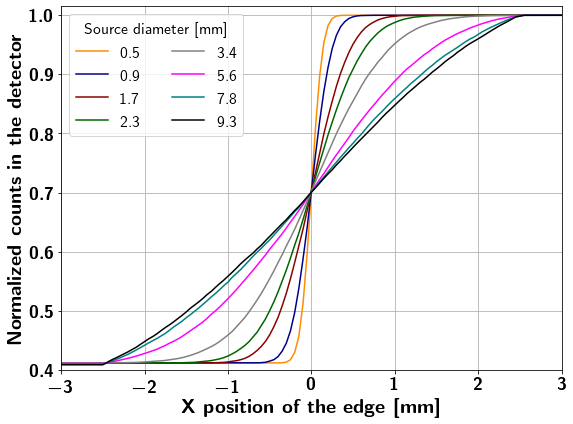

In [36]:
diameters = data['diameter'].unique()
ids = [4,8,16,22,33,55,77,92]
colors = ['darkorange', 'darkblue', 'darkred', 'darkgreen', 'gray', 'magenta', 'teal', 'black']
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
fs = 20
markersize = 10
outputfolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/emitting_spot_size_lookup_table/'
figname = 'explain_code_esf'

for idx, color in zip(ids, colors):
    diameter = diameters[idx]

    # select only that diameter
    df = data[ data['diameter'] == diameter ]
    df = df.sort_values(by='x_pos')
    
    # normalize the countrate by the lower end ones
    higher_countrates = df[ df['x_pos'] > 5 ]
    mean_higher_countrates = np.mean(higher_countrates['counts'])
    df['counts_normalized'] = df['counts'] / mean_higher_countrates
#     print(mean_lower_countrates)
    # plot
    X = df['x_pos'].values
    y = df['counts_normalized'].values
    plt.plot(X,y, color=color, label=f'{diameter:.1f}')

plt.xlabel(r'\textbf{X position of the edge [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Normalized counts in the detector}', fontsize=fs)

ax1.tick_params('x', colors='black', labelsize=fs-2)
ax1.tick_params('y', colors='black', labelsize=fs-2)

ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')

leg = plt.legend(fontsize=fs-4, loc='best', ncol=2)
leg.set_title(r'Source diameter [mm]', prop = {'size': fs-4,})
plt.tight_layout()

plt.xlim(-3,3)
plt.ylim(0.4,1.015)
plt.savefig(f'{outputfolder}/{figname}.pdf')
plt.show()

### 3. Plot some FWHMs

The gaussian function is computing using the FWHM and

$$f(x,\sigma,\mu) = \frac{1}{\sigma \cdot \sqrt{2\cdot \pi}} \text{exp}\left[-\frac{\left(x-\mu\right)^2}{2\cdot \sigma^2}\right]$$

and setting $\mu=0$, calculating $\sigma$ from $\sigma = \frac{\text{FWHM}}{\sqrt{8\cdot \text{ln}\left[2\right]}}$. Where FWHM is computed from the ESF formula.

0.2198822171942835 0.5
0.3972775660076218 0.8999999999999999
0.752713165143031 1.7000000000000002
1.0212218498967833 2.3000000000000003
1.5150341971757284 3.4000000000000004
2.4031263767765587 5.6000000000000005
2.9696636191724717 7.800000000000002
3.2054539961289588 9.3


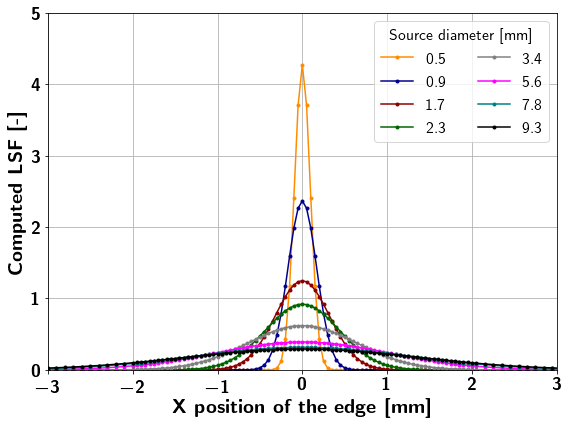

In [39]:
def fun_calculate_FWHM_of_ESF(
    # calculate the FWHM of the LSF fitted to the ESF
    # return FWHM, Y_log_fermi_func, p1, r_squared
    X,  # X values from the ESF (in mm) 
    Y,  # Y values from the ESF (can be anything)
    p0 # initial guess for the fit
    ):

    # log_fermi_func_zboray
    def fitfunc(p, x):
        z = np.exp( -( (x-p[1])/(p[2]) ) )
        return (p[0] / ( 1 + z )) + p[3]
    def errfunc(p, x, y):
        return fitfunc(p, x) - y # Distance to the fit function


    # m = np.mean(Y[0:5])
    # p0 = [5e+03, 5e-2, radius, m] # Initial guess for the parameters
    p1, success = optimize.leastsq(errfunc, p0[:], args=(X, Y))

    # r-squared
    residuals = Y - fitfunc(p1, X)
    ss_residuals = np.sum(residuals**2)   # residual sum of squares
    ss_tot =  np.sum((Y-np.mean(Y))**2) # total sum of squares
    r_squared = 1 - (ss_residuals / ss_tot)
    FWHM = 3.53 * p1[2]

    Y_log_fermi_func = fitfunc(p1, X)

    # return the FWHM from the 3.53c (logistic fit) and 
    # Y_log_fermi_func: is the Y values for the plot of the log fermi function

    return FWHM, Y_log_fermi_func, p1, r_squared

def gauss_func(x,sigma,mu):
    return ((1/(sigma*np.sqrt(2*np.pi))*np.exp(-((x-mu)**2/(2*(sigma)**2)))))

diameters = data['diameter'].unique()
ids = [4,8,16,22,33,55,77,92]
colors = ['darkorange', 'darkblue', 'darkred', 'darkgreen', 'gray', 'magenta', 'teal', 'black']
p0 = [1, 1e-3, 1e-1, 5e3]
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
fs = 20
markersize = 3
outputfolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/emitting_spot_size_lookup_table/'
figname = 'explain_code_FWHM'

for idx, color in zip(ids, colors):
    diameter = diameters[idx]

    # select only that diameter
    df = data[ data['diameter'] == diameter ]
    df = df.sort_values(by='x_pos')
    
#     # normalize the countrate by the lower end ones
#     higher_countrates = df[ df['x_pos'] > 5 ]
#     mean_higher_countrates = np.mean(higher_countrates['counts'])
#     df['counts_normalized'] = df['counts'] / mean_higher_countrates
# #     print(mean_lower_countrates)
#     # plot
    X = df['x_pos'].values
    y = df['counts'].values

    FWHM, Y_log_fermi_func, p1, r_squared = fun_calculate_FWHM_of_ESF(X,y,p0)
    # compute sigma from the gaussian function
    sigma = np.abs(FWHM)/(np.sqrt(8*np.log(2)))
    # plot the FWHM curve
    print(np.abs(FWHM),diameter)
    plt.plot(X,gauss_func(X,sigma,0), color=color, label=f'{diameter:.1f}', markersize=markersize, marker='o')

plt.xlabel(r'\textbf{X position of the edge [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Computed LSF [-]}', fontsize=fs)

ax1.tick_params('x', colors='black', labelsize=fs-2)
ax1.tick_params('y', colors='black', labelsize=fs-2)

ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')

leg = plt.legend(fontsize=fs-4, loc='best', ncol=2)
leg.set_title(r'Source diameter [mm]', prop = {'size': fs-4,})
plt.yticks(np.arange(0,6,1))
plt.ylim(0,5)
plt.xlim(-3,3)
plt.tight_layout()


plt.savefig(f'{outputfolder}/{figname}.pdf')
plt.show()

In [ ]:
def fun_calculate_FWHM_of_ESF(
	# calculate the FWHM of the LSF fitted to the ESF
	# return FWHM, Y_log_fermi_func, p1, r_squared
	X,  # X values from the ESF (in mm) 
	Y,  # Y values from the ESF (can be anything)
	p0 # initial guess for the fit
	):

	# log_fermi_func_zboray
	def fitfunc(p, x):
		z = np.exp( -( (x-p[1])/(p[2]) ) )
		return (p[0] / ( 1 + z )) + p[3]
	def errfunc(p, x, y):
		return fitfunc(p, x) - y # Distance to the fit function


	# m = np.mean(Y[0:5])
	# p0 = [5e+03, 5e-2, radius, m] # Initial guess for the parameters
	p1, success = optimize.leastsq(errfunc, p0[:], args=(X, Y))

	# r-squared
	residuals = Y - fitfunc(p1, X)
	ss_residuals = np.sum(residuals**2)   # residual sum of squares
	ss_tot =  np.sum((Y-np.mean(Y))**2) # total sum of squares
	r_squared = 1 - (ss_residuals / ss_tot)
	FWHM = 3.53 * p1[2]
	
	Y_log_fermi_func = fitfunc(p1, X)
	
	# return the FWHM from the 3.53c (logistic fit) and 
	# Y_log_fermi_func: is the Y values for the plot of the log fermi function
	
	return FWHM, Y_log_fermi_func, p1, r_squared

def find_nearest(array,value):
	idx = (np.abs(array-value)).argmin()
	return idx

def fit_FWHM(df,Y_colname):
	# returns the FWHM for a given X, Y
	# X is the edge position
	# Y is the countrate or the counts in the detector

	case = df['case'].unique()[0]
	diameter = df['diameter'].unique()[0]
	# if (case == 167) & (diameter == 3.0):  # do only one diameter
	if case > -1:  # always valid
		
		

		print('Processing case {}, diameter {} mm.'.format(case, diameter))

		X = df['x_pos'].values
		Y = df[Y_colname].values


		def fitfunc(x, *p):
			a, b, c, d = p
			z = np.exp( -( (x-b)/(c) ) )
			# z = np.exp( -( (x-p[1])/(p[2]) ) )
			return (a / ( 1 + z )) + d
			# return (p[0] / ( 1 + z )) + p[3]


		# for mm in list(itertools.product(m,m,m,m)):
		# 	p0 = [mm[0],mm[1],mm[2],mm[3]]
			# FWHM, Y_log_fermi_func, p1, r_squared = fun_calculate_FWHM_of_ESF(x, y, p0)
		p0 = [1, 1e-3, 1e-1, 1e3]
		popt, pcov = curve_fit(fitfunc, X, Y, p0=p0, maxfev=1000000)
		# print(popt)
		FWHM_0 = np.abs(3.53*popt[2])  # 3.53 * c in fermi function


		# if FWHM_0 > 100:
		# 	print('FWHM {} LARGER THAN 100! Exit.'.format(FWHM_0))
		# 	sys.exit()
		# print('FWHM_0: {} '.format(FWHM_0))
		p1_0 = popt
		print('p1_0: {} '.format(p1_0))

		###################################################
		# fit again with 0 +/- 1 FWHM and three points more!
		###################################################
		
		# idx_X_pos = find_nearest(X,FWHM_0)


		# idx_X_neg = find_nearest(X,-FWHM_0)


		# print('{:.1f}'.format(diameter))
		# if '{:.1f}'.format(diameter) == '3.5':
		# 	plt.scatter(X,Y)
		# 	plt.show()
		# offset_points = 10
		# i_max = idx_X_pos+offset_points
		# i_min = idx_X_neg-offset_points
		# if (i_min > 0) & (i_max <= len(X)):
		# 	X = X[i_min:i_max]
		# 	Y = Y[i_min:i_max]a<Y
		# 	print(idx_X_neg, idx_X_pos)



		p0 = [1, 1e-3, 1e-1, 1e3]
		popt, pcov = curve_fit(fitfunc, X, Y, p0=p0, maxfev=1000000)
		# print(popt)
		FWHM = np.abs(3.53*popt[2])  # 3.53 * c in fermi function
		print('FWHM: {} '.format(FWHM))
		
		
			# r-squared
		residuals = Y - fitfunc(X, *popt)
		ss_residuals = np.sum(residuals**2)   # residual sum of squares
		ss_tot =  np.sum((Y-np.mean(Y))**2) # total sum of squares
		r_squared = 1 - (ss_residuals / ss_tot)
		# print(p1)
		# a = [-1e6, -1e5, -1e4, -1e3, -1e2, -1e1,-1e-1, -1e-2, -1e-3, -1e-4, 0, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
		# b = [-1e6, -1e5, -1e4, -1e3, -1e2, -1e1,-1e-1, -1e-2, -1e-3, -1e-4, 0, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
		# c = [-1e6, -1e5, -1e4, -1e3, -1e2, -1e1,-1e-1, -1e-2, -1e-3, -1e-4, 0, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
		# d = [-1e6, -1e5, -1e4, -1e3, -1e2, -1e1,-1e-1, -1e-2, -1e-3, -1e-4, 0, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
	 
		# for kk in list(itertools.product(a,b,c,d)):
			# p0 = [kk[0], kk[1], kk[2], kk[3]] # Initial guess for the parameters			
			# FWHM, Y_log_fermi_func, p1, r_squared = fun_calculate_FWHM_of_ESF(X, Y, p1_0)
					
			# if (p1[1] > 1e-3) & (p1[1] < 100):  # computed FWHM larger than 0
				# print(p1)
				# break


		print('Plotting fit to ESF for case {}, diameter {} mm.'.format(case, diameter))


		fig, ax = plt.subplots(1)
		X_fit = np.sort(X)
		# print(X_fit)	
		Y_log_fermi_func = fitfunc(X_fit, *popt)
		ax.plot(X_fit, Y_log_fermi_func, color='darkblue', label='ESF fit')
		
		ax.scatter(X, Y, edgecolor='darkorange', label='MCNP data', color='darkorange')
		# print(X,Y)
		# ax.scatter([X[idx_X_neg],X[idx_X_pos]], [Y[idx_X_neg],Y[idx_X_pos]], edgecolor='red', color='red', marker='x', s=120)
			
			# FWHM, Y_log_fermi_func, p1, r_squared = compute_FWHM(X, df_poisson.iloc[:,ii].values,rad)
			
		ax.tick_params('x', colors='black', labelsize=12)	
		ax.tick_params('y', colors='black', labelsize=12)	
		# grid
		ax.grid(b=True, which='major', linestyle='-')#, color='gray')
		ax.grid(b=True, which='minor', linestyle='--')#, color='gray')
		plt.title('Case: {:.0f}, Diameter: {:.2f} mm'.format(case, diameter))
		plt.legend(loc='best')
		plt.xlabel('Edge position [mm]')
		plt.ylabel('Countrate for tot. Neutron Yield: {:.1e} n/s'.format(S0))
		plt.tight_layout()
		# plt.show()
		plt.savefig('{}ESF_fit_plots/diameter_{:.2f}_mm_case_{:.0f}_ESF_fit.png'.format(master_folder, diameter, case), dpi=100)
		plt.clf()
		plt.close('all')


		# print into file! 
		fname = '{}ESF_fit_csv/case_{}_diameter_{}_mm_ESF_fit.csv'.format(master_folder,case,diameter)
		this_df = pd.DataFrame()
		this_df['x_pos_mm'] = X
		this_df[Y_colname] = Y
		this_df['Y_log_fermi_func'] = Y_log_fermi_func
		this_df.to_csv(fname)

		return pd.Series(np.abs(3.53*popt[2]), index = ['FWHM'])